## Building and running a simulation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py

import tidy3dclient as td
from tidy3dclient import web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize structures, sources and probes

In this example, we will simulate a rectangular dielectric Box pierced by a triangular pillar made of lossy dielectric. First we initialize some general simulation parameters.

In [2]:
# Resolution in x, y, z (points per micron)
resolution = 40

# Simulation domain size (in micron)
sim_size = [5, 5, 5]

# Central frequency of interest in Hz
fcen = 2e14

# Total time to run in seconds
run_time = 1.5e-12

# Number of PML layers to use along each of the three directions.
pml_layers = [12, 12, 12]

Next, we initialize two different structures made of two different materials.

In [3]:
# Lossless dielectric
material1 = td.Medium(epsilon=6.)
# Lossy dielectric defined from real and imaginary part of the refractive index
material2 = td.Medium.from_nk(n=1.5, k=0.1, freq=fcen)

# Rectangular box
box = td.Box(center=[0, 0, 0], size=[2, 3, 1], material=material1)
# Triangle in the xy-plane with a finite extent in z
poly = td.PolySlab(vertices=[[-0.5, -0.5], [0.5, -0.5], [0, 1]], 
                z_cent=0,
                z_size=2,
                material=material2)

Next, we define a source and some field probes. Here, the excitation is a 2D plane-wave source spanning the whole simulation domain at a given cross-section. We also define a time probe recording the E-field at a point in the center of the simulation domain, and two frequency probes recording the DFT of the E-field at the central frequency in two different 2D planes.

In [4]:
psource = td.PlaneSource(normal='x',
                         pos_offset=-1.5,
                         f0=fcen,
                         fwidth=1e13,
                         polarization='y')

tprobe = td.TimeProbe(center=[0, 0, 0], size=[0, 0, 0])
fprobe1 = td.FreqProbe(center=[1.5, 0, 0], size=[0, 20, 20], freqs=[fcen])
fprobe2 = td.FreqProbe(center=[0, 0, 0], size=[20, 20, 0], freqs=[fcen])

### Create and inspect the simulation

Now we can initialize the simulation with all the elements defined above.

In [5]:
# Initialize simulation
sim = td.Simulation(size=sim_size,
                    resolution=resolution, 
                    structures=[box, poly], 
                    sources=[psource], 
                    probes=[tprobe, fprobe1, fprobe2],
                    run_time=run_time,
                    pml_layers=pml_layers)

Initializing simulation...
Simulation domain in number of pixels: 200, 200, 200.
Mesh step (micron): 2.50e-02, 2.50e-02, 2.50e-02.
Total number of time steps: 34618.
Estimated data size of probe tprobe1: 0.0004GB.
Estimated data size of probe fprobe1: 0.0005GB.
Estimated data size of probe fprobe2: 0.0005GB.


We can use an in-built plotting function to make sure that the source time dependence makes sense with respect to the total simulation time.

Tidy3D GaussianSource:
name         = source1
center       = [-1.5000 0.0000 0.0000] 
size         = [0.0000 5.0000 5.0000] 
f0           = 2.00e+14
fwidth       = 1.00e+13
polarization = y
offset       = 5.00
amplitude    = 1.00e+00



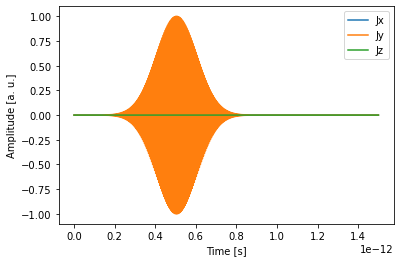

In [6]:
print(sim.sources[0])
td.viz.source_time(sim.sources[0]);

We also use an in-built plotting function to visualize the simulation. We plot three cross sections at `z=0`, `y=0`, and `x=0`, respectively. The relative permittivity of objects is plotted in greyscale. By default, sources are overlayed in green, probes in yellow, and PML boundaries in orange, but each of those can be switched off with the corresponding tag. 

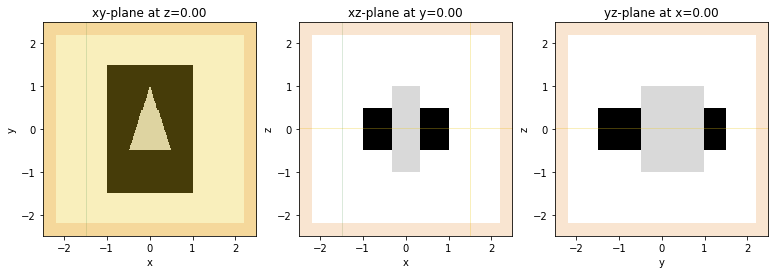

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
td.viz.relative_eps(sim, normal='z', ax=ax[0], sources=True, probes=True, pml=True);
td.viz.relative_eps(sim, normal='y', ax=ax[1], sources=True, probes=True, pml=True);
td.viz.relative_eps(sim, normal='x', ax=ax[2], sources=True, probes=True, pml=True);

The left-most image is entirely overlaid in yellow to show the frequency probe at z=0.

### Run the simulation

Now that the simulation is constructed, we can run it using the `web` API of Tidy3D. First, we submit the project. Note that we can give it a custom name.

In [8]:
project = web.newProject(sim.export(), taskName='Simulation test')

We can monitor the status of all our projects by listing them in chronological order of submission.

In [9]:
# Check status (of the last 5 submitted projects)
web.listProjects(5)

Project name: Simulation test-6
Task ID     : ad0739af-cd3c-4e49-98b8-1460a3746538
Submit time : 2021:01:06:03:37:26
Status      : queued
--------------------------------------------------
Project name: Simulation test-5
Task ID     : 0565e95f-c4d0-48d7-a021-d6e082f857e2
Submit time : 2021:01:06:03:31:19
Status      : success
--------------------------------------------------
Project name: MZI-4
Task ID     : 7d9e9094-24b9-4a7c-96bc-2d078677ff5c
Submit time : 2021:01:05:03:33:31
Status      : success
--------------------------------------------------
Project name: MZI-phase-shifter
Task ID     : 1b81c52b-736f-4645-98f3-160d157ef1b3
Submit time : 2021:01:05:03:26:55
Status      : success
--------------------------------------------------
Project name: MZI-2
Task ID     : 2b19b062-b5ee-4637-b158-bbd68f707a07
Submit time : 2021:01:05:01:37:05
Status      : success
--------------------------------------------------


Or, we can continously monitor the status of the current project, and wait until the run is successful. The `monitorProject()` function will keep running until either a `'success'` or `'error'` status is returned.

In [10]:
web.monitorProject(project['taskId'])

Project "Simulation test-6" status: success...       

## Loading and analyzing data

After a successful run, we can download the results and load them into our simulation model. We use the `downloadResults` function from our web API, which downloads a single `hdf5` file containing all the probe data, a log file, and a `json` file defining the original simulation (same as what you'll get if you run `sim.export_json()` on the current object). Optionally, you can provide a folder in which to store the files.

In [11]:
web.downloadResults(project['taskId'], target_folder='out/')
# Show the output of the log file
!cat out/tidy3d.log

Simulation domain Nx, Ny, Nz: 200, 200, 200.
Total number of nodes (after symmetries, if any): 8.00e+06.
Total number of time steps: 34618.
Starting Tidy3D... 

Setup time (s): 0.3543
Solver time (s): 44.6787
Post-processing time (s): 0.5377


### Load a simulation from JSON file

In case we are returning to a project for which we do not have an active simulation object, we can re-initialize the simulation from the freshly downloaded `json` file. Below, we load the file from the project we just ran, and load the ouput data downloaded from the server.

**NB**: when running the notebook from the beginning, it is not needed to call `import_json()`, as the current Simulation is stored in memory. Here we do it to illustrate how this function can be used, essentially re-initializing the same Simulation.

In [12]:
sim = td.Simulation.import_json("out/simulation.json")
sim.load_results('out/probe_data.hdf5')

### Visualization functions

Finally, we can now use the in-built visualization tools to examine the results. Below, we plot the `y`-component of the field recorded by the two frequency probes (this is the dominant component since the source is `y`-polarized).

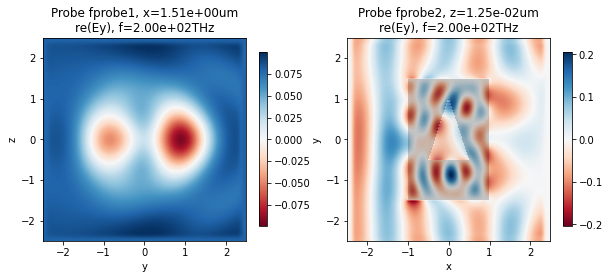

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
td.viz.fprobe_2D(sim, probe_ind=0, ax=ax[0], cbar=True, comp='y', val='re');
td.viz.fprobe_2D(sim, probe_ind=1, ax=ax[1], cbar=True, comp='y', val='re');

### Raw data in Simulation object and in hdf5 file
The raw data is also accessible as numpy arrays. Each frequency probe for example has attribute `E` that stores the data as a 5D array with shape (3, Nx, Ny, Nz, Nfreqs), where the first dimension is polarization, and the last dimension is the number of frequencies in the frequency probe.

In [14]:
print(sim.fprobes[0])
print("\n")
print("Size of E-field array stored in probe 0: ", sim.fprobes[0].E.shape)
print("Size of corresponding mesh in x        : ", sim.fprobes[0].xmesh.shape)
print("Size of corresponding mesh in y        : ", sim.fprobes[0].ymesh.shape)
print("Size of corresponding mesh in z        : ", sim.fprobes[0].zmesh.shape)

Tidy3D FreqProbe:
name     = fprobe1
center   = [1.5000 0.0000 0.0000] 
size     = [0.0000 20.0000 20.0000] 
freqs    = [2.00e+14] 

Store E:  True
Store H:  False
Has data: xmesh, ymesh, zmesh, freqs, E


Size of E-field array stored in probe 0:  (3, 1, 200, 200, 1)
Size of corresponding mesh in x        :  (1,)
Size of corresponding mesh in y        :  (200,)
Size of corresponding mesh in z        :  (200,)


We can use this raw data for example to also plot the time-domain fields recorded in the TimeProbe, which look largely like a delayed version of the source input, indicating that no resonant features were excited.

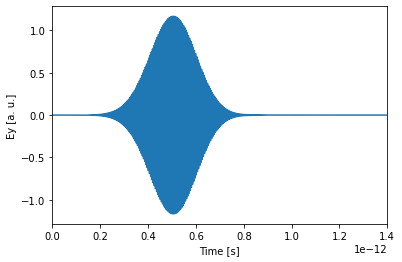

In [15]:
fig, ax = plt.subplots(1)
ax.plot(sim.tprobes[0].tmesh, sim.tprobes[0].E[1, 0, 0, 0, :])
ax.set_xlim(0, 1.4e-12)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Ey [a. u.]")
plt.show()

Finally, the raw data is also accessible through the `hdf5` file. 

In [16]:
# Open the data file and print stored groups and datasets
probe_file = h5py.File("out/probe_data.hdf5", "r")
print("Data groups stored in file:   ", list(probe_file.keys()))
print("Datasets in 'fprobe_fprobe1': ", list(probe_file['fprobe_fprobe1'].keys()))

# Read the E-field of the second FreqProbe
E_hdf5 = np.array(probe_file['fprobe_fprobe2']['E'])
x_hdf5 = np.array(probe_file['fprobe_fprobe2']['xmesh'])
y_hdf5 = np.array(probe_file['fprobe_fprobe2']['ymesh'])

# Close the file
probe_file.close()

Data groups stored in file:    ['fprobe_fprobe1', 'fprobe_fprobe2', 'tprobe_tprobe1']
Datasets in 'fprobe_fprobe1':  ['E', 'H', 'freqs', 'indspan', 'xmesh', 'ymesh', 'zmesh']


We can plot the field using the in-built function, or do it manually.

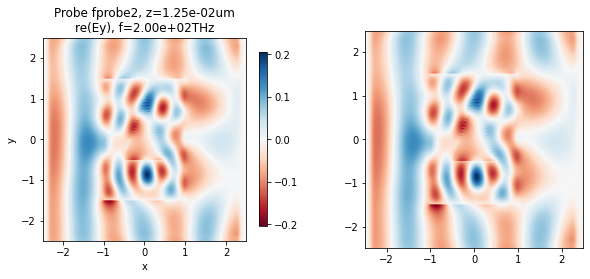

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Built-in Tidy3D viz
td.viz.fprobe_2D(sim, probe_ind=1, ax=ax[0], cbar=True, comp='y', val='re', eps=False);
# Manually from data loaded from the hdf5 file
ax[1].imshow(np.real(E_hdf5[1, :, :, 0, 0]).T, cmap='RdBu', origin='lower',
                extent=[x_hdf5[0], x_hdf5[-1], y_hdf5[0], y_hdf5[-1]])
plt.show()